# PREDICTIVE YIELD CURVE MODELING
<i>An Application of Principal Component Analysis to euro yield curves</i>
***
The term structure of interest rates (“yield curve”) is a representation that plots bonds of the same type (e.g. credit quality, sector) in terms of their prices, expressed as yields, over different maturity dates. This project sets out to study the yield curve dynamics in reduced dimensionality. In literature Principal Component Analysis (PCA) is a known application to this use case.

<u>After a successful yield curve decomposition the following topics will be tackled:</u>
- Supporting the interpretation of the first 3 principal components (PCs) in accordance with traditional (shift,slope,curvature) factors
- Testing out-of-sample fit for model yield curves, generated from reduced principal components set
- Derivation of non-linear stress scenarios for each component (1-month ahead 95% confidence)
- Testing predictability with an autoregressive timeseries model

The underlying data represents Euro area AAA government spot rate yield curves. They have been retrieved for a time horizon starting from 01-01-2015 to 31.12.2020 on a daily basis.

<br>
<img src="../assets/img/source.png", width = "700">
<br>
Data is available at: <u>https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html</u> (accessed 18.02.2021)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-Libraries" data-toc-modified-id="1-Libraries-1">1 Libraries</a></span></li><li><span><a href="#2-Parameters" data-toc-modified-id="2-Parameters-2">2 Parameters</a></span></li><li><span><a href="#3-Data" data-toc-modified-id="3-Data-3">3 Data</a></span><ul class="toc-item"><li><span><a href="#3.1-Data-Cleaning" data-toc-modified-id="3.1-Data-Cleaning-3.1">3.1 Data Cleaning</a></span></li><li><span><a href="#3.2-Visuals" data-toc-modified-id="3.2-Visuals-3.2">3.2 Visuals</a></span></li><li><span><a href="#3.3-Dynamic" data-toc-modified-id="3.3-Dynamic-3.3">3.3 Dynamic</a></span></li></ul></li><li><span><a href="#4-Principal-Component-Analysis" data-toc-modified-id="4-Principal-Component-Analysis-4">4 Principal Component Analysis</a></span><ul class="toc-item"><li><span><a href="#4.1-Eigen-Vectors" data-toc-modified-id="4.1-Eigen-Vectors-4.1">4.1 Eigen Vectors</a></span></li><li><span><a href="#4.2-Eigen-Scores" data-toc-modified-id="4.2-Eigen-Scores-4.2">4.2 Eigen Scores</a></span></li><li><span><a href="#4.3-Yield-Curve-Factors" data-toc-modified-id="4.3-Yield-Curve-Factors-4.3">4.3 Yield Curve Factors</a></span></li><li><span><a href="#4.4-In-Sample-Fit" data-toc-modified-id="4.4-In-Sample-Fit-4.4">4.4 In-Sample Fit</a></span></li><li><span><a href="#4.5-Out-Of-Sample-Fit" data-toc-modified-id="4.5-Out-Of-Sample-Fit-4.5">4.5 Out-Of-Sample Fit</a></span></li><li><span><a href="#4.6-Dynamic" data-toc-modified-id="4.6-Dynamic-4.6">4.6 Dynamic</a></span></li></ul></li><li><span><a href="#5-Stationarity-Analysis" data-toc-modified-id="5-Stationarity-Analysis-5">5 Stationarity Analysis</a></span><ul class="toc-item"><li><span><a href="#5.1-Original-Series" data-toc-modified-id="5.1-Original-Series-5.1">5.1 Original Series</a></span></li><li><span><a href="#5.2-First-Differences" data-toc-modified-id="5.2-First-Differences-5.2">5.2 First Differences</a></span></li></ul></li><li><span><a href="#6-Stress-Scenarios" data-toc-modified-id="6-Stress-Scenarios-6">6 Stress Scenarios</a></span></li><li><span><a href="#7-Prediction" data-toc-modified-id="7-Prediction-7">7 Prediction</a></span><ul class="toc-item"><li><span><a href="#7.1-Model-Fit" data-toc-modified-id="7.1-Model-Fit-7.1">7.1 Model Fit</a></span></li><li><span><a href="#7.2-Model-Results" data-toc-modified-id="7.2-Model-Results-7.2">7.2 Model Results</a></span></li><li><span><a href="#7.3-Actuals" data-toc-modified-id="7.3-Actuals-7.3">7.3 Actuals</a></span></li><li><span><a href="#7.4-Benchmark" data-toc-modified-id="7.4-Benchmark-7.4">7.4 Benchmark</a></span></li><li><span><a href="#7.5-Error" data-toc-modified-id="7.5-Error-7.5">7.5 Error</a></span></li></ul></li><li><span><a href="#8-Evaluation" data-toc-modified-id="8-Evaluation-8">8 Evaluation</a></span></li></ul></div>

### 1 Libraries
***

In [1]:
# Data preparation
import datetime as dt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from sklearn.preprocessing import StandardScaler

# Custom libraries
import yieldcurves as yc
import principalcomponents as pc
import autoregressive as ar

In [2]:
# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib.pyplot import cm
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
sns.set()

# Date formats
days_loc   = mdates.DayLocator(interval = 7)
months_loc = mdates.MonthLocator()
years_loc  = mdates.YearLocator()

days_fmt   = mdates.DateFormatter("%Y-%m-%d")
months_fmt = mdates.DateFormatter("%Y-%m")
years_fmt  = mdates.DateFormatter('%Y')

In [3]:
# Autocorrelation & Stationarity
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
def rainbow(categories):
    """
    This function generates a dictionary of color codes for each category.
    """
    c_scale = cm.rainbow(np.linspace(0,1,len(categories)))
    c_dict = {}

    for i,c in zip(categories,c_scale):
        c_dict[i] = c
        
    return c_dict

In [5]:
def underline(string):
    chr_start = "\033[4m"
    chr_end = "\033[0m"
    print(chr_start + string + chr_end)

### 2 Parameters
***

In [6]:
# Choose the maturities that should be used for calculation
maturities = [0.25, 0.5, 1, 2, 3 , 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

# Choose the maturities that should be depicted in charts
maturities_visual = [0.25, 0.5, 2, 5, 10, 14, 20, 26, 30]

In [7]:
# Parameters for data preparation 
widg_start = widgets.DatePicker(description = "Start date", value = dt.date(2005,1,4), disabled = False)
widg_end   = widgets.DatePicker(description = "End date",   value = dt.date(2021,1,1), disabled = False)
widg_freq  = widgets.Dropdown(options = ["day", "week", "month"], 
                              value = "day", 
                              description = "Frequency:",
                              disabled = False)

In [8]:
# Widget for start date of testing window
widg_test = widgets.DatePicker(description = "Test start", value = dt.date(2018,1,1), disabled = False)

# Widget if time series shall be differenced
widg_diff = widgets.Dropdown(options=[True,False], value=True, description="Differencing:")

# Widget for number of principal components
widg_k = widgets.IntSlider(value=3, min=3, max=20, step=1,
                           description = "# PC:",
                           orientation = "horizontal",
                           readout = True)

# Widget for number of lags in model
widg_lag = widgets.IntSlider(value=5, min=1, max=50, step=1,
                             description="# Lags:",
                             orientation="horizontal",
                             readout=True)

# Widget for number of forecast steps
widg_steps = widgets.IntSlider(value=100, min=1, max=500, step=1,
                               description = "# Steps:",
                               orientation = "horizontal",
                               readout = True)

In [9]:
underline ("Data Parameters:")
display(widg_start)
display(widg_end)
display(widg_freq)

print ("\n")

underline ("Model Parameters")
display (widg_test)
display (widg_diff)
display (widg_k)
display (widg_lag)
display (widg_steps)

Data Parameters:


DatePicker(value=datetime.date(2005, 1, 4), description='Start date')

DatePicker(value=datetime.date(2021, 1, 1), description='End date')

Dropdown(description='Frequency:', options=('day', 'week', 'month'), value='day')



Model Parameters


DatePicker(value=datetime.date(2018, 1, 1), description='Test start')

Dropdown(description='Differencing:', options=(True, False), value=True)

IntSlider(value=3, description='# PC:', max=20, min=3)

IntSlider(value=5, description='# Lags:', max=50, min=1)

IntSlider(value=100, description='# Steps:', max=500, min=1)

In [10]:
# Store data prep parameters
start_date = widg_start.value.strftime("%Y-%m-%d")
end_date   = widg_end.value.strftime("%Y-%m-%d")
frequency  = widg_freq.value

# Store model parameters
test_start = widg_test.value.strftime("%Y-%m-%d")
diff  = widg_diff.value
k     = widg_k.value
lag   = widg_lag.value
steps = widg_steps.value

### 3 Data
***

#### 3.1 Data Cleaning

In [11]:
# Import euro yield curves
raw_rates = yc.import_rates(filepath = "../assets/files/01-input/",
                            filename = "data.csv")

In [12]:
# Filter and clean data
clean_rates = yc.clean_rates(df    = raw_rates,
                             start = start_date, 
                             end   = end_date, 
                             freq  = frequency, 
                             maturities = maturities)

In [13]:
clean_rates.head()

,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,...,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
2005-01-04,2.055906,2.115073,2.231982,2.457144,2.667102,2.859640,3.034202,3.191244,3.331801,3.457203,...,3.835797,3.969342,4.076773,4.164136,4.236022,4.295884,4.346320,4.389285,4.426264,4.458392
2005-01-05,2.064858,2.126695,2.248179,2.479969,2.694019,2.888871,3.064513,3.221795,3.362033,3.486758,...,3.861299,3.992777,4.098339,4.184064,4.254532,4.313175,4.362560,4.404618,4.440808,4.472248
2005-01-06,2.060515,2.107919,2.207488,2.415567,2.622265,2.818094,2.998407,3.161485,3.307315,3.436821,...,3.820866,3.952938,4.057725,4.142005,4.210780,4.267707,4.315469,4.356040,4.390893,4.421138
2005-01-07,2.048016,2.092720,2.187889,2.390159,2.593648,2.787782,2.967263,3.129985,3.275709,3.405230,...,3.789565,3.921729,4.026567,4.110870,4.179653,4.236581,4.284340,4.324908,4.359757,4.389998
2005-01-10,2.034898,2.081488,2.179831,2.386555,2.592692,2.788282,2.968441,3.131341,3.276929,3.406124,...,3.788533,3.919747,4.023743,4.107319,4.175479,4.231876,4.279180,4.319355,4.353864,4.383808


In [14]:
# Transform numeric maturities into string format (%Y%M)
mat_vis = [yc.maturity_transform(i) for i in maturities_visual]
mat_all = [yc.maturity_transform(i) for i in maturities]

# Get list of last available dates per each month
eomonth = clean_rates.loc[clean_rates \
                     .groupby(clean_rates.index.to_period("M")) \
                     .apply(lambda x: x.index.max())].index


# Get list of last available dates per each year
eoyear = clean_rates.loc[clean_rates \
                    .groupby(clean_rates.index.to_period("Y")) \
                    .apply(lambda x: x.index.max())].index

In [15]:
# Train-test split for actual yields
clean_rates_train = clean_rates[clean_rates.index < test_start]
clean_rates_test  = clean_rates[clean_rates.index >= test_start]

#### 3.2 Visuals

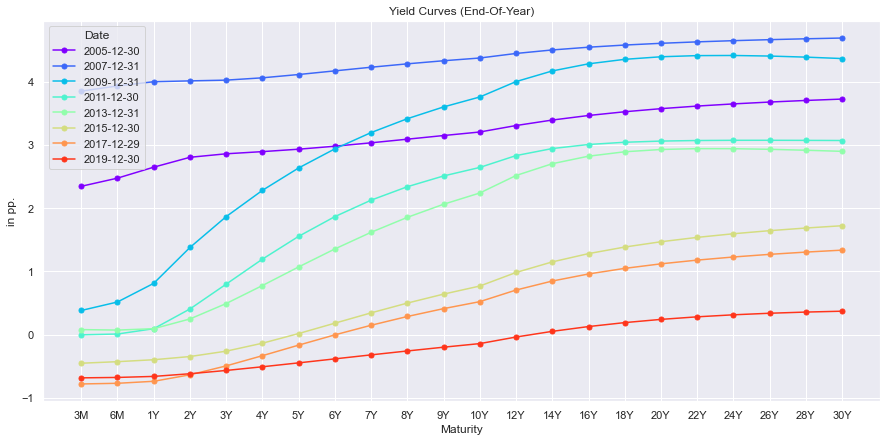

In [16]:
# Depict yield curves per each observed year end
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
color = rainbow(eoyear)

for i,j in enumerate(eoyear):
    if i%2==0: 
        ax.plot(clean_rates.loc[j], marker="o", markersize=5, c=color[j], label=j.date())
    

ax.set_title ("Yield Curves (End-Of-Year)")
ax.set_xlabel ("Maturity")
ax.set_ylabel ("in pp.")
ax.legend(title="Date", loc="upper left")

plt.show()

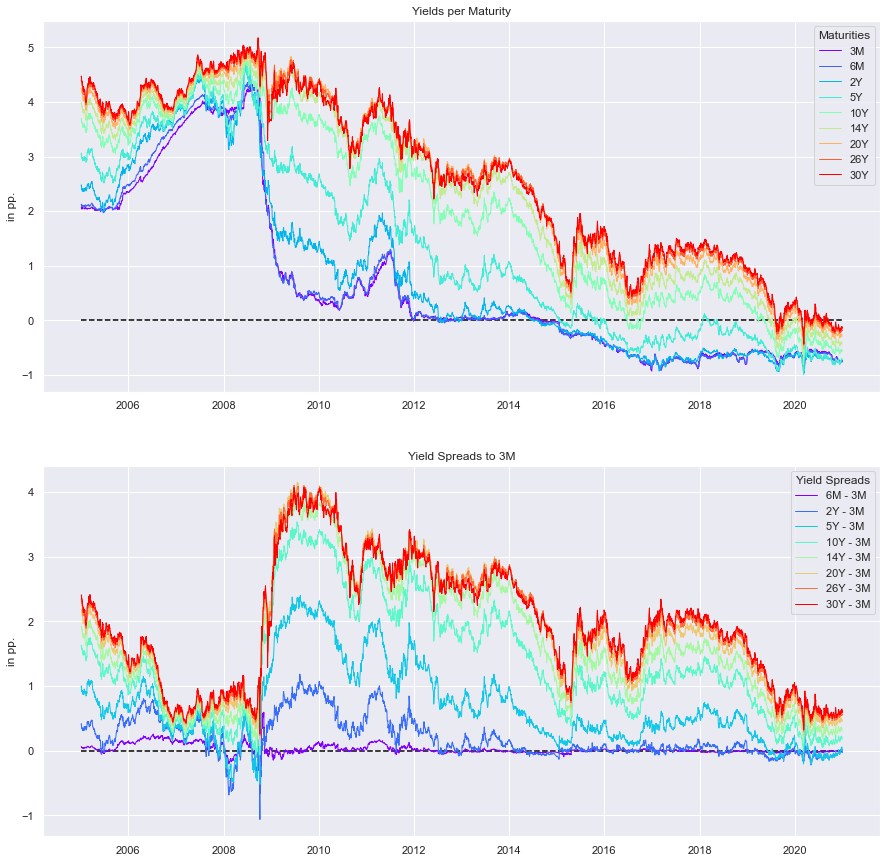

In [17]:
# Depicting yields for various maturities over time
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,15))


# Subplot #1
color = rainbow(mat_vis)
for i in mat_vis: ax1.plot (clean_rates[i], c = color[i], label = i, linewidth=1)

ax1.hlines(y=0, 
           xmin=min(clean_rates.index), 
           xmax=max(clean_rates.index), 
           colors="black", 
           linestyles="dashed")


# Subplot #2
color = rainbow(mat_vis[1:])
for i in mat_vis[1:]: plt.plot (clean_rates[i] - clean_rates.iloc[:,0], c = color[i], label = i+" - 3M", linewidth=1)
     
ax2.hlines(y=0, 
           xmin=min(clean_rates.index), 
           xmax=max(clean_rates.index), 
           colors="black", 
           linestyles="dashed", 
           label="")


# Formatting
ax1.set_title ("Yields per Maturity")
ax1.set_ylabel ("in pp.")
ax1.legend(title = "Maturities", loc = "upper right")

ax2.set_title ("Yield Spreads to 3M")
ax2.set_ylabel ("in pp.")
ax2.legend(title = "Yield Spreads", loc = "upper right")

plt.show()

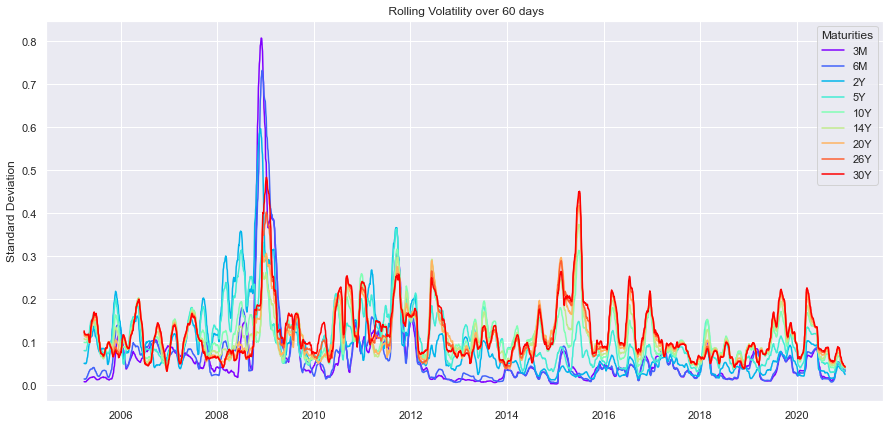

In [18]:
# Insert time window for rolling volatility (in units of previously defined frequency)
roll_window = 60
roll_vola = clean_rates.rolling(roll_window).std().iloc[roll_window-1:]

# Depicting rolling volatility for various maturities over time
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
color = rainbow(mat_vis)

for i in mat_vis:
    ax.plot (roll_vola[i], c = color[i], label = i)

# Formatting
ax.set_title (f' Rolling Volatility over {roll_window} {widg_freq.value}s')
ax.set_ylabel ("Standard Deviation")
ax.legend(title="Maturities", loc="upper right")

plt.show()

#### 3.3 Dynamic

In [19]:
# Notebook backend is necessary to display animated plots
%matplotlib notebook

In [20]:
# (1) Creating figure 
fig, (ax1, ax2) = plt.subplots(2, figsize=(9,8))
plt.subplots_adjust(hspace=0.25)
color = rainbow(["yield","lag","delta"])

# (2) Preparing objects
df = clean_rates[2500:].copy()
x = df.iloc[1].index
y = df.iloc[1]

# (3) Initializing objects
yields_lag,   = ax1.plot(x, y, marker='o', markersize=4, c=color["lag"])
yields_now,   = ax1.plot(x, y, marker='o', markersize=4, c=color["yield"])
yields_delta, = ax2.plot(x, y, marker='o', markersize=4, c=color["delta"])

# (4) Fixed formatting
ax1_min = np.floor(df.values.min())
ax1_max = np.ceil(df.values.max())
ax1.set_ylim(ax1_min, ax1_max)

ax1.set_title(start_date)
ax1.set_ylabel("in pp.", fontsize=8)
ax1.tick_params(axis="both", which="major", labelsize=8)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax2.set_ylabel("in pp.", fontsize=8)
ax2.tick_params(axis="both", which="major", labelsize=8)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


# (5) Animation function
def animate(i):
    
    # (5.1) Define number of steps delta
    f_dict = {"day":250, "week":52,"month":12}
    f_factor = f_dict[frequency]
    j = max(min(i-1,f_factor),0)

    # (5.2) Updating new data
    yields_now  .set_ydata(df.iloc[i])
    yields_lag  .set_ydata(df.iloc[i-j])
    yields_delta.set_ydata(df.iloc[i] - df.iloc[i-j])
    
    # (5.3) Area chart needs to be cleared and initialized
    ax2.collections.clear()
    ax2.fill_between(x, df.iloc[i] - df.iloc[i-j], 0, color = color["delta"], alpha = 0.2)
    
    # (5.4) Variable formatting
    date_now = df.index[i].strftime("%Y-%m-%d")
    date_lag = df.index[i-j].strftime("%Y-%m-%d")
    
    ax1.legend(loc = "lower right", fontsize = 8)     
    ax1.set_title("Euro AAA Government Yield Curve ("+date_now+")", fontsize = 10)
    ax2.set_title("Euro AAA Goverment Yield Curve (1Y Delta)", fontsize = 10)

    yields_now.set_label(date_now)
    yields_lag.set_label(date_lag)
        
    ax2_min = min(np.floor((df.iloc[i] - df.iloc[i-j]).values.min()),-2)
    ax2_max = max(np.ceil((df.iloc[i] - df.iloc[i-j]).values.max()),2)
    ax2.set_ylim(ax2_min, ax2_max)
 
    
# (6) Animation iterating through the play array
ani = FuncAnimation(fig, animate, np.arange(1,len(df),10), interval=1, blit=True)
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
ani.save("../assets/img/yields.gif", writer="Pillow")

In [124]:
%matplotlib inline

### 4 Principal Component Analysis
***

In [157]:
pc_model = pc.PCA(spot = clean_rates, 
                  maturities = mat_all, 
                  k = k)

pc_scores   = pc_model.eig_scores_k
pc_vect     = pc_model.eig_vect_k
pc_vect_inv = pc_model.eig_vect_inv_k
pc_yields   = pc_model.yields
pc_idx      = pc_model.idx[:k]
pc_idx2     = pc_model.idx[:3]

#### 4.1 Eigen Vectors

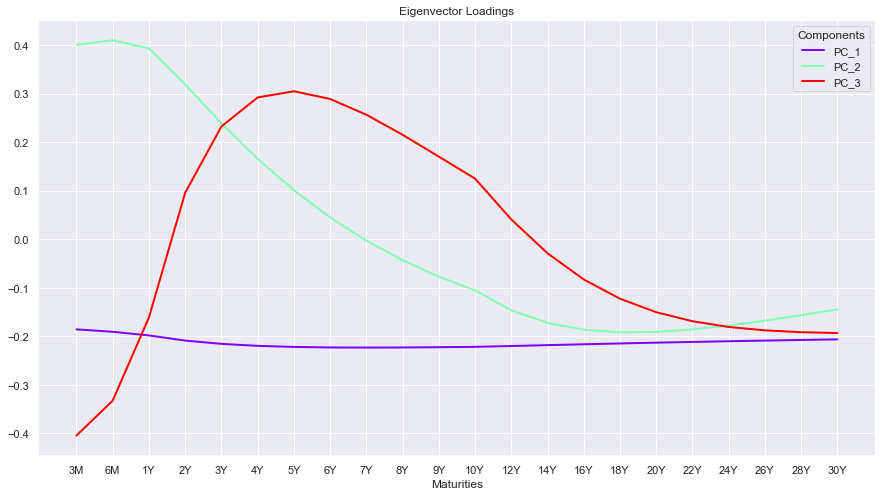

In [23]:
# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
color = cm.rainbow(np.linspace(0,1,3))

for i,c in zip(pc_idx2, color):
    ax.plot(pc_vect[i], c=c, label=i, linewidth=2)

# Formatting
ax.set_title ("Eigenvector Loadings")
ax.set_xlabel ("Maturities")
ax.legend(title="Components")

plt.show()

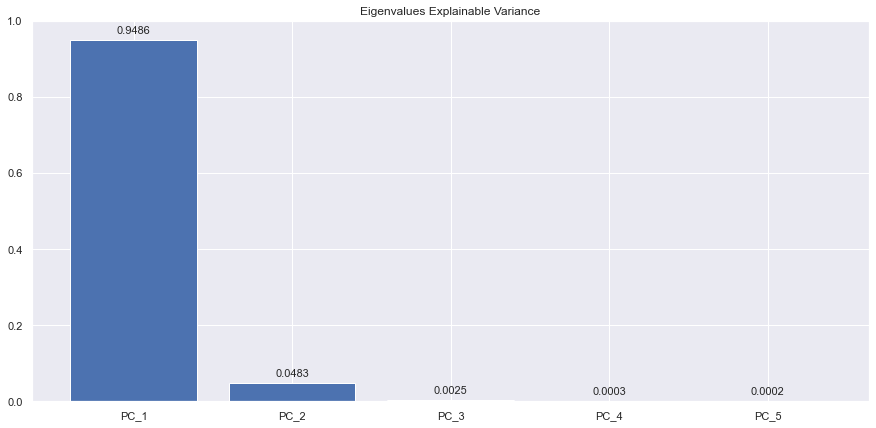

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15,7))

# Plotting
ax.bar(pc_model.eig_vals.index[:5], pc_model.eig_vals["eig_val_rel"][:5])
ax.set_ylim(0,1)
ax.set_title ("Eigenvalues Explainable Variance")

# Annotations
for p in ax.patches:
    x_val = p.get_x()
    y_val = p.get_height()
    bar   = p.get_width()/2

    ax.annotate(text = str(round(y_val,4)), 
                xy = (x_val+bar, y_val+0.025), 
                ha = "center", 
                va = "center",
                fontsize = 11)

plt.show()

#### 4.2 Eigen Scores

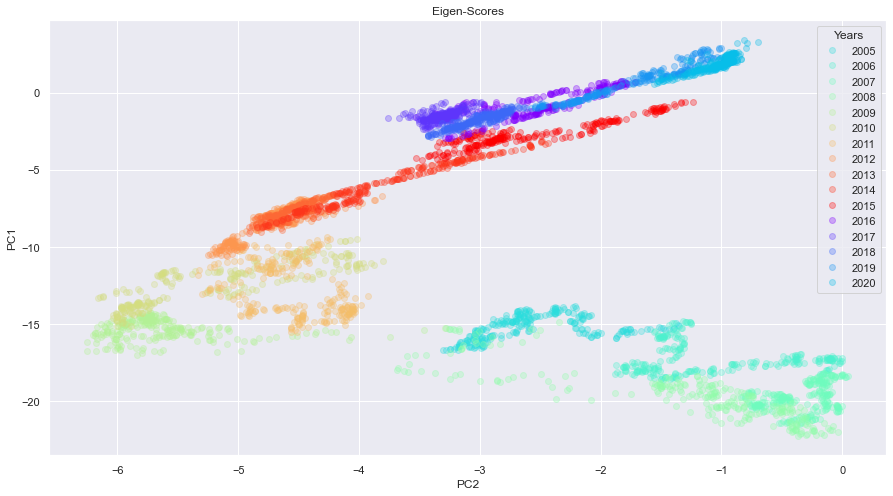

In [25]:
# Define colors
color = rainbow(set(pc_scores.index.year))

# Prepare data for visualization
temp         = pc_scores.copy()
temp["year"] = pc_scores.index.year
temp         = temp.groupby("year")


# Create plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))

for label, data in temp:
    ax.plot(data["PC_2"], data["PC_1"], c=color[label], marker="o", linestyle="", alpha=0.3, label=label)


# Formatting
ax.set_title("Eigen-Scores")
ax.set_ylabel("PC1")
ax.set_xlabel("PC2")
plt.legend(title="Years")

plt.show()

#### 4.3 Yield Curve Factors

In [26]:
scaler = StandardScaler()

# Scaled principal components
pc_1 = scaler.fit_transform(pc_scores["PC_1"].values.reshape(-1, 1))*-1
pc_2 = scaler.fit_transform(pc_scores["PC_2"].values.reshape(-1, 1))*-1
pc_3 = scaler.fit_transform(pc_scores["PC_3"].values.reshape(-1, 1))

# Classicla yield curve factors
lvl   = scaler.fit_transform(clean_rates["10Y"].values.reshape(-1, 1))
slope = scaler.fit_transform((clean_rates["10Y"] - clean_rates["6M"]).values.reshape(-1, 1))
curve = scaler.fit_transform((clean_rates["6M"] + clean_rates["10Y"] - 2*clean_rates["5Y"]).values.reshape(-1, 1))

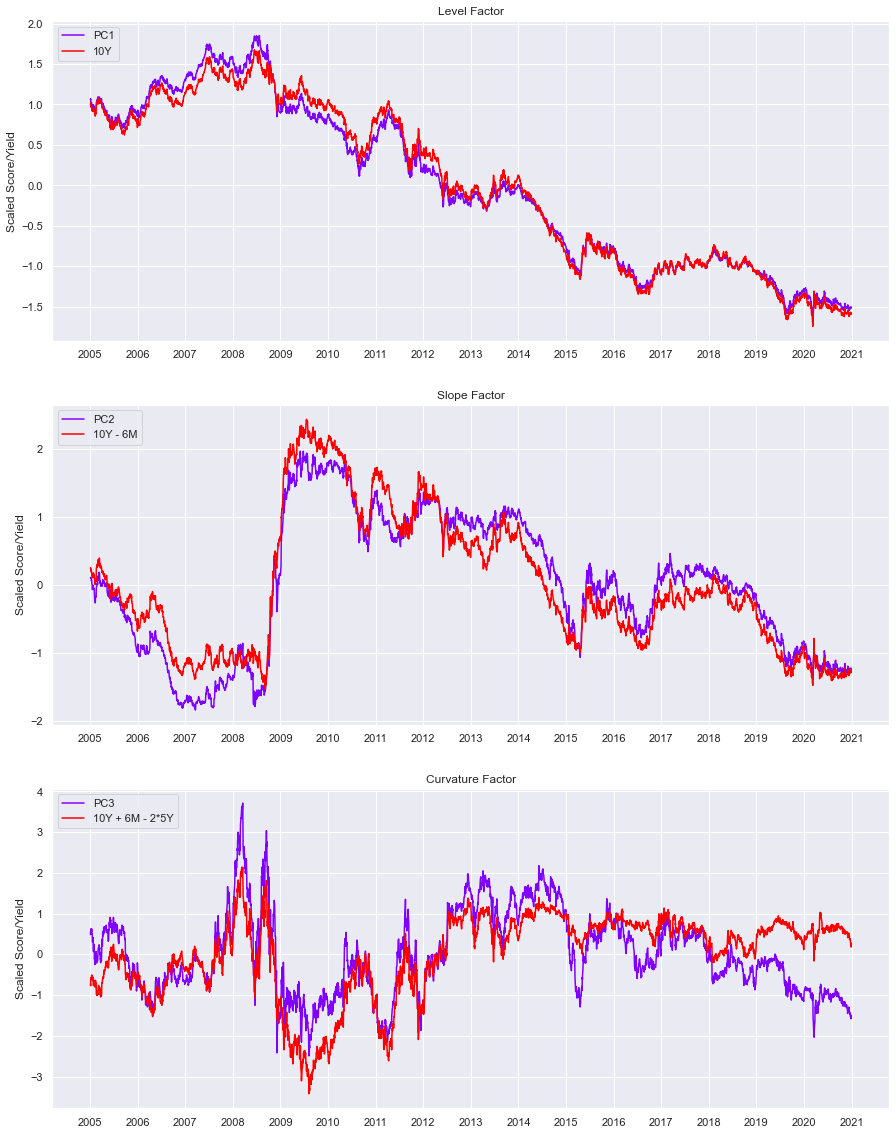

In [27]:
fig, ax = plt.subplots(3, 1, figsize = (15,20))
colors = rainbow(["PC","YC"])

# Create plot
ax[0].plot(pc_scores.index, pc_1, label="PC1", c=colors["PC"])
ax[0].plot(pc_scores.index, lvl,  label="10Y", c=colors["YC"])

ax[1].plot(pc_scores.index, pc_2, label="PC2", c=colors["PC"])
ax[1].plot(pc_scores.index, slope,label="10Y - 6M", c=colors["YC"])

ax[2].plot(pc_scores.index, pc_3*-1, label="PC3", c=colors["PC"])
ax[2].plot(pc_scores.index, curve,label="10Y + 6M - 2*5Y", c=colors["YC"])


# Formatting
ax[0].set_title ("Level Factor")
ax[1].set_title ("Slope Factor")
ax[2].set_title ("Curvature Factor")

for i in range (3):
    ax[i].xaxis.set_major_formatter(years_fmt)
    ax[i].xaxis.set_major_locator(years_loc)
    ax[i].xaxis.set_minor_locator(months_loc)
    
    ax[i].set_ylabel ("Scaled Score/Yield")
    ax[i].legend(loc = "upper left")

plt.show()

#### 4.4 In-Sample Fit

In [28]:
# RMSE 
e = (pc_yields - clean_rates)**2
rmse = pd.Series(data = e.T.mean())**0.5
rmse_year = e.groupby(e.index.year).mean()**0.5

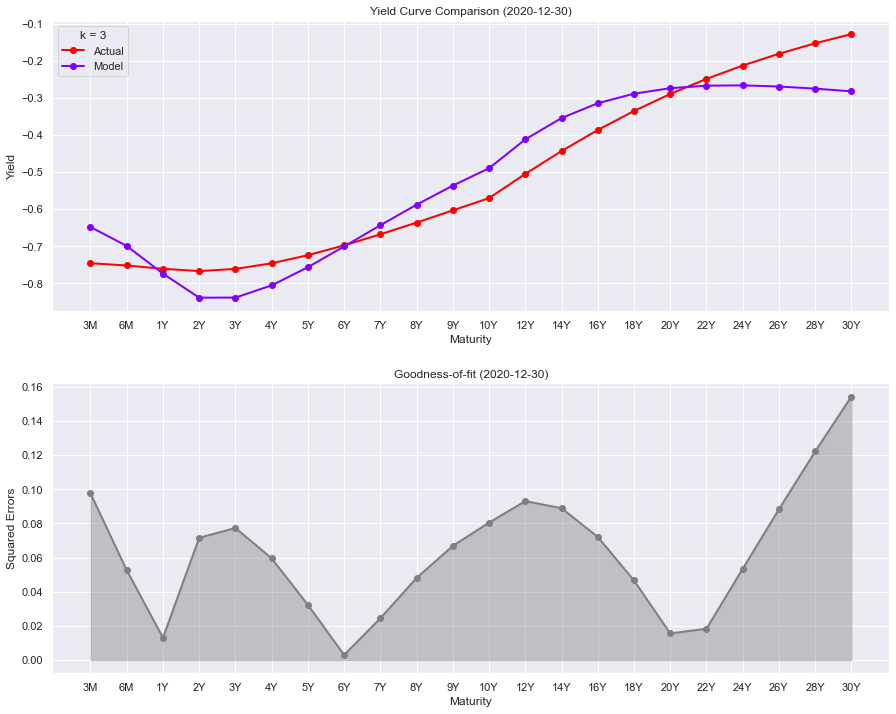

In [29]:
chart_date = eoyear[-1].strftime("%Y-%m-%d")
x = pc_yields.loc[chart_date,:]
y = clean_rates.loc[chart_date,:]
e = np.sqrt((x-y)**2)

# Create plot
fig, ax = plt.subplots(2, 1, figsize = (15,12))

ax[0].plot(y, label="Actual", c=colors["YC"], linewidth=2, marker="o")
ax[0].plot(x, label="Model",  c=colors["PC"], linewidth=2, marker="o")

ax[1].plot(e, c="grey", linewidth=2, marker="o")
ax[1].fill_between(x.index, e, color="grey", alpha=0.4)


# Formatting
ax[0].set_xlabel("Maturity")
ax[0].set_ylabel("Yield")
ax[0].set_title(f"Yield Curve Comparison ({chart_date})")

ax[1].set_xlabel("Maturity")
ax[1].set_ylabel("Squared Errors")
ax[1].set_title(f"Goodness-of-fit ({chart_date})")

ax[0].legend(title = "k = "+str(k))
plt.subplots_adjust(hspace=0.25)
plt.show()

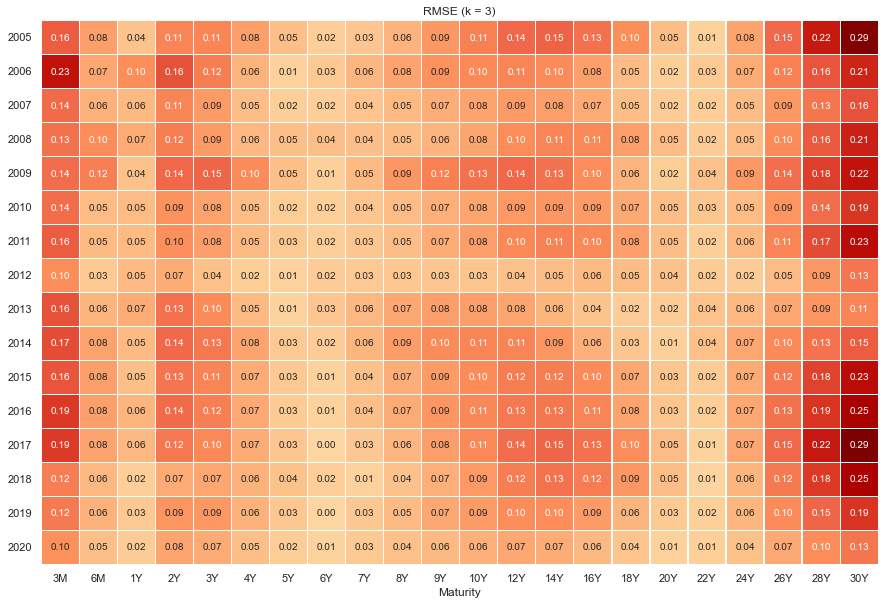

In [31]:
fig, ax = plt.subplots(1, 1, figsize = (15,10))

sns.heatmap(rmse_year, 
            fmt=".2f", 
            cmap = "OrRd", 
            linewidth = 0.3, 
            annot = True,
            cbar = False,
            center = 0.1)


ax.title.set_text("RMSE (k = "+str(k)+")")
ax.set(xlabel="Maturity")

for label in ax.yaxis.get_ticklabels():
    label.set_verticalalignment("center")
    label.set_rotation(0)

plt.show()

#### 4.5 Out-Of-Sample Fit

In [32]:
# Initialize PCA object class
temp = pc.PCA(spot=clean_rates_train, maturities=mat_all, k=k)

# Use out-of-sample function to derive model test yields fitting on eigen-vectors from train-set
pc_yields_oos = temp.pca_oos(eig_vect_train = temp.eig_vect, spot_test = clean_rates_test)
pc_yields_oos.iloc[:5,:10]

,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y
2018-01-02,-0.511905,-0.649112,-0.797046,-0.786773,-0.615287,-0.400173,-0.180502,0.029169,0.222819,0.397819
2018-01-03,-0.475969,-0.615544,-0.771735,-0.777206,-0.617107,-0.410000,-0.195937,0.009848,0.200856,0.374120
2018-01-04,-0.459152,-0.596443,-0.749654,-0.753537,-0.594569,-0.389622,-0.178089,0.025091,0.213573,0.384473
2018-01-05,-0.450713,-0.590065,-0.747819,-0.758078,-0.602442,-0.399093,-0.188130,0.015111,0.204042,0.375615
2018-01-08,-0.440049,-0.582188,-0.746499,-0.766636,-0.616681,-0.416456,-0.207034,-0.004319,0.184735,0.356837


In [33]:
# RMSE 
e_oos = (pc_yields_oos - clean_rates_test)**2
rmse_oos = pd.Series(data = e_oos.T.mean())**0.5
rmse_oos[0] = rmse[rmse_oos.index[0]]

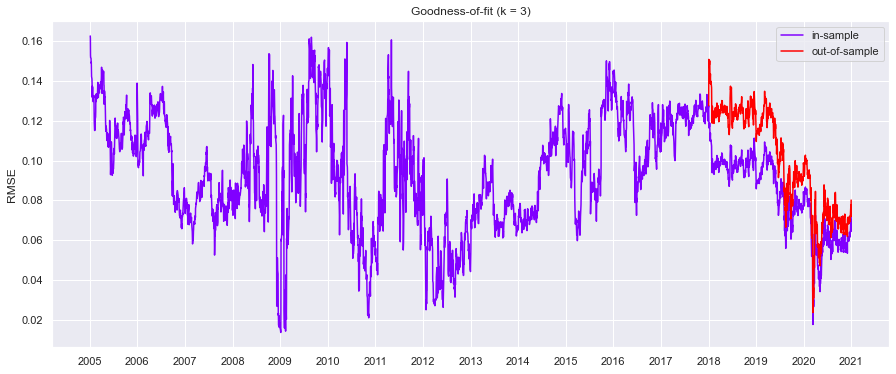

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
color = rainbow(["in-sample","out-of-sample"])

# Plots
ax.plot (rmse, c=color["in-sample"], label="in-sample")
ax.plot (rmse_oos, c=color["out-of-sample"], label="out-of-sample")

# Formatting
ax.set_title ("Goodness-of-fit (k = "+ str(k) + ")")
ax.set_ylabel ("RMSE")
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_major_locator(years_loc)
ax.xaxis.set_minor_locator(months_loc)
ax.legend()

plt.show()

#### 4.6 Dynamic

In [35]:
%matplotlib notebook

In [36]:
# (1) Creating figure
fig, (ax1, ax2) = plt.subplots(2, figsize=(9, 10))
fig.suptitle("Euro AAA Government Yield Curve", y=0.92)
plt.subplots_adjust(hspace = 0.25)
color = rainbow(["actual","error_3","error_2","-","-","-"])


# (2) Prepare objects
y1 = clean_rates[2800:].copy()
y2 = pc.PCA(spot = clean_rates, maturities = mat_all, k = 2).yields[2800:]
y3 = pc.PCA(spot = clean_rates, maturities = mat_all, k = 3).yields[2800:]
e2 = np.sqrt((y1-y2)**2)
e3 = np.sqrt((y1-y3)**2)
x  = y1.columns


# (3) Initialize objects
yc_model_2, = ax1.plot(x, y2.iloc[0,:], '-o', markersize=4, c=color["error_2"], label="model (k=2)", alpha=0.5)
yc_model_3, = ax1.plot(x, y3.iloc[0,:], '-o', markersize=4, c=color["error_3"], label="model (k=3)", alpha=0.5)
yc_actual,  = ax1.plot(x, y1.iloc[0,:], '-o', markersize=4, c=color["actual"], label="actual")

yc_error_2, = ax2.plot(x, e2.iloc[0,:], '-o', markersize=4, c=color["error_2"], label="rmse")
yc_error_3, = ax2.plot(x, e3.iloc[0,:], '-o', markersize=4, c=color["error_3"], label="rmse")


# (4) Fixed formatting
ax1.set_title("Evaluation of Fit", fontsize = 10)           # Title
ax1.set_ylabel("in pp.", fontsize=8)                        # Axis label title
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))   # Axis number formatting
ax1.tick_params(axis="both", which="major", labelsize=8)    # Axis ticks

ax1_min = np.floor(y1.values.min())                         # Axis minimum
ax1_max = np.ceil(y1.values.max())                          # Axis maximum
ax1.set_ylim(ax1_min, ax1_max)                              # Axis threshold

ax2.set_title("RMSE of Fit", fontsize = 10)                 # Title
ax2.set_ylabel("in pp.", fontsize=8)                        # Axis label title
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))   # Axis number formatting
ax2.tick_params(axis="both", which="major", labelsize=8)    # Axis ticks


# (5) Animation function
def animate(i):

    # (5.1) Adding new data
    yc_actual .set_ydata(y1.iloc[i,:])
    yc_model_2.set_ydata(y2.iloc[i,:])
    yc_model_3.set_ydata(y3.iloc[i,:])
    yc_error_2.set_ydata(e2.iloc[i,:])
    yc_error_3.set_ydata(e3.iloc[i,:])
    
    # (5.2) Area chart needs to be cleared and initialized
    ax2.collections.clear()
    ax2.fill_between(x, e2.iloc[i,:], 0, color = color["error_2"], alpha = 0.2)
    ax2.fill_between(x, e3.iloc[i,:], 0, color = color["error_3"], alpha = 0.2)
    
    # (5.3) Variable formatting
    date = y1.index[i].strftime("%Y-%m-%d")
    
    ax1.legend(loc = "lower center", fontsize = 8, title = "Yield Curve", title_fontsize = 8)
    ax1.set_title("Model Fit ("+date+")", fontsize = 8)
    
    ax2.legend(loc = "upper center", fontsize = 8)
    ax2.set_title("Squared Errors ("+date+")", fontsize = 8)
    
    # Variable y-axis
    ax1_min = np.floor(y1.iloc[i,:].min())-0.5
    ax1_max = np.ceil(y1.iloc[i,:].max())+0.5
    ax1.set_ylim(-1.5, 2)
    
    # Update legend with RMSE
    rmse_2 = round(np.sqrt((e2.iloc[i,:]**2)).mean(),2)
    rmse_3 = round(np.sqrt((e3.iloc[i,:]**2)).mean(),2)
    yc_error_2.set_label("model k=2 error: "+str(rmse_2))
    yc_error_3.set_label("model k=3 error: "+str(rmse_3))

    
# (6) Animation iterating through the steps array
ani = FuncAnimation(fig, animate, np.arange(1,len(y1),10), interval=1, blit=True)
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
ani.save("../assets/img/pc-fit-dyn.gif", writer="Pillow")

In [41]:
# (1) Creating figure
fig, (ax1, ax2) = plt.subplots(2, figsize=(9, 10))
plt.subplots_adjust(hspace = 0.25)


# (2) Prepare objects
y1 = clean_rates[2500:].copy()
x1 = y1.columns
y2 = pc_scores["PC_1"][2500:]
x2 = pc_scores["PC_2"][2500:]
color = rainbow(np.arange(len(y2)))


# (3) Initialize objects
chart_yield,  = ax1.plot(x1, y1.iloc[0,:],         marker="o", markersize=4, c=color[0], label="actual")
chart_pc_run, = ax2.plot(x2[0], y2[0], c=color[0], marker="o", linestyle="", alpha = 0.3)
chart_pc_new, = ax2.plot(x2[0], y2[0], c="red",    marker="o", linestyle="")


# (4) Fixed formatting - Subplot #1
ax1.set_title("Yield Curve", fontsize = 10)                              # Title
ax1.set_ylabel("in pp.", fontsize=8)                                     # Axis label title
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))                # Axis number formatting
ax1.tick_params(axis="both", which="major", labelsize=8)                 # Axis ticks

ax1_min = np.floor(y1.values.min())                                      # Axis minimum
ax1_max = np.ceil(y1.values.max())                                       # Axis maximum
ax1.set_ylim(ax1_min, ax1_max)                                           # Axis threshold


# (4) Fixed formatting - Subplot #2
ax2.set_title("Yield Curve in Reduced Dimensionality", fontsize=10)      # Title
ax2.set_ylabel("PC 1", fontsize=8)                                       # Axis label title
ax2.set_xlabel("PC 2", fontsize=8)                                       # Axis label title

ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))                # Axis number formatting
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))                # Axis number formatting
ax2.tick_params(axis="both", which="major", labelsize=8)                 # Axis ticks

ax2.set_xlim(np.floor(x2.min())-1, np.ceil(x2.max())+1)
ax2.set_ylim(np.floor(y2.min())-1, np.ceil(y2.max())+1)  


# (5) Animation function
def animate(i):

    # (5.1) Adding new data
    chart_yield.set_ydata(y1.iloc[i,:])
    chart_yield.set_color(color[i])
    
    chart_pc_run.set_data(x2[:i], y2[:i])
    chart_pc_run.set_color(color[i])
    
    chart_pc_new.set_data(x2[i], y2[i])
    
    # (5.2) Variable formatting
    date = y1.index[i].strftime("%Y-%m-%d")
    ax1.set_title("Yield Curve ("+date+")", fontsize = 10)

    
# (6) Animation iterating through the steps array
ani = FuncAnimation(fig, animate, np.arange(1,len(y1),10), interval=1, blit=True)
plt.show()

<IPython.core.display.Javascript object>

In [42]:
ani.save("../assets/img/pc-scores-dyn.gif", writer="Pillow")

MovieWriter Pillow unavailable; using Pillow instead.


In [43]:
%matplotlib inline

### 5 Stationarity Analysis
***

#### 5.1 Original Series

The Augmented Dickey-Fuller (ADF) test can be applied, to statistically testify stationarity. Basically ADF runs a regression to forecast the first differences (Y) from on the original time series (X). The resulting t-statistic gives the ADF-statistic.
- <u>Stationary:</u> When t-stat is significant. A stationary time series would be mean-reverting immediately, enabling the original time to predict the next change.
- <u>Non-Stationary:</u> When t-stat is not significant. 

In [44]:
def adf_test(df, col, alpha):
    """
    This function applies the ADF-test for a respective time series at a certain confidence interval
    Required parameters:
    - df:         DataFrame -> Data under rewiew
    - cols:       List -> List of columns to apply ADF on
    - confidence: Str -> ["1%","5%","10%"]
    """
    model  = adfuller(df[col])
    result = dict()
    
    result["adf_stat"]  = round(model[0],4)
    result["p_val"]     = round(model[1],4)
    result["threshold"] = round(model[4][alpha],4)
    
    if result["adf_stat"] < result["threshold"]:
        result["stationary"] = "yes"
    else:
        result["stationary"] = "no"
    
    return result

In [45]:
for i in pc_idx[:min(3,k)]:
    underline (f'Stationarity-Test: {i}')
    print (adf_test(df = pc_scores, col = i, alpha = "5%"))

Stationarity-Test: PC_1
{'adf_stat': -0.1913, 'p_val': 0.9395, 'threshold': -2.8622, 'stationary': 'no'}
Stationarity-Test: PC_2
{'adf_stat': -1.1533, 'p_val': 0.6934, 'threshold': -2.8622, 'stationary': 'no'}
Stationarity-Test: PC_3
{'adf_stat': -3.3052, 'p_val': 0.0146, 'threshold': -2.8623, 'stationary': 'yes'}


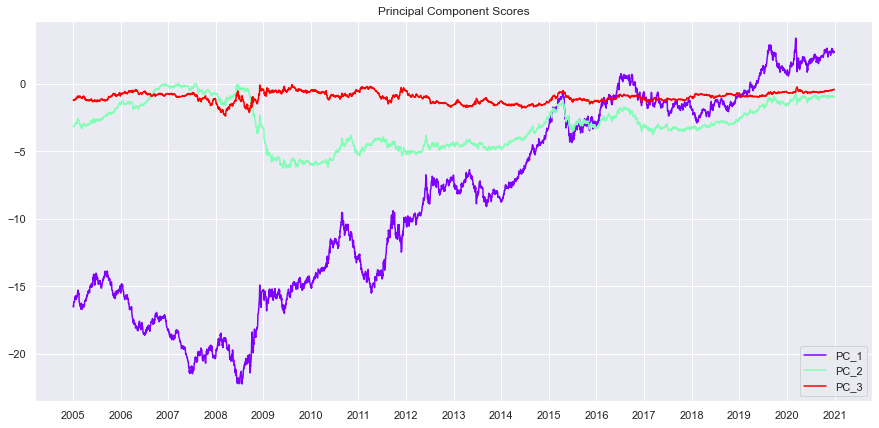

In [46]:
fig, ax = plt.subplots(1, 1, figsize = (15,7))
colors = rainbow(pc_idx[:min(3,k)])

# Plotting
for i in pc_idx[:min(3,k)]:
    plt.plot(pc_scores[i], c = colors[i], label = i)

# Formatting
ax.set_title ("Principal Component Scores")
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_major_locator(years_loc)
ax.xaxis.set_minor_locator(months_loc)

ax.legend(loc = "lower right")
plt.show()

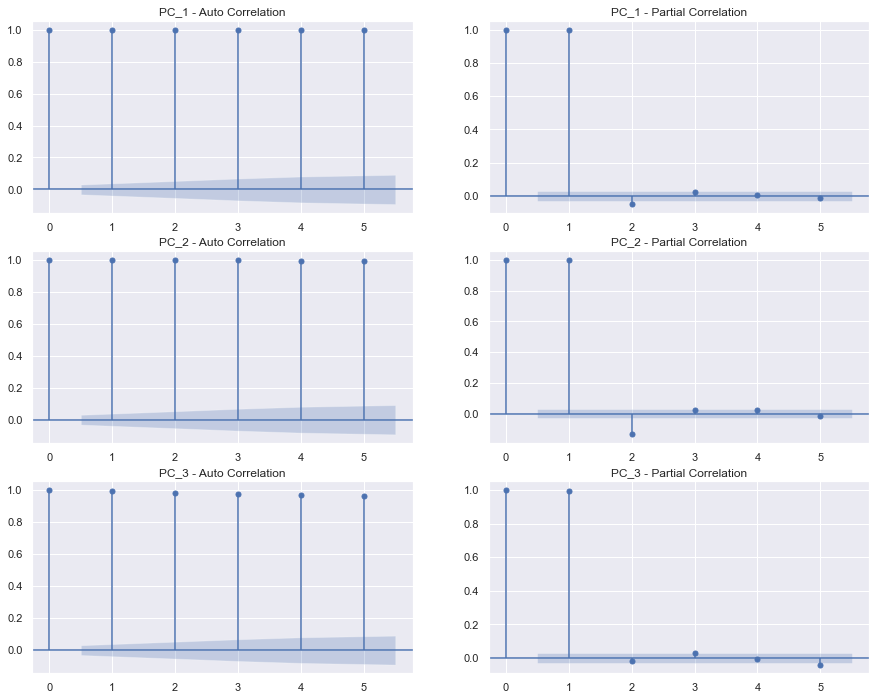

In [47]:
fig, ax = plt.subplots(k, 2, figsize=(15,4*k))

for i,j in enumerate (pc_idx):
    plot_acf (pc_scores[j], lags= lag, ax=ax[i][0], title=j+" - Auto Correlation")
    plot_pacf(pc_scores[j], lags= lag, ax=ax[i][1], title=j+" - Partial Correlation")

plt.show()

#### 5.2 First Differences

In [158]:
periods = 1
for i in pc_idx:
    pc_scores[i+"_diff"] = pc_scores[i].diff(periods)    
    
pc_scores = pc_scores.iloc[periods:]
pc_scores.head()

,PC_1,PC_2,PC_3,PC_1_diff,PC_2_diff,PC_3_diff
2005-01-05,-16.535461,-3.177109,-1.163551,-0.103321,-0.000939,0.026507
2005-01-06,-16.311676,-3.173812,-1.208708,0.223784,0.003297,-0.045157
2005-01-07,-16.176023,-3.156397,-1.216691,0.135654,0.017416,-0.007983
2005-01-10,-16.161456,-3.163570,-1.199021,0.014567,-0.007173,0.017670
2005-01-11,-16.153977,-3.090635,-1.188675,0.007479,0.072935,0.010346


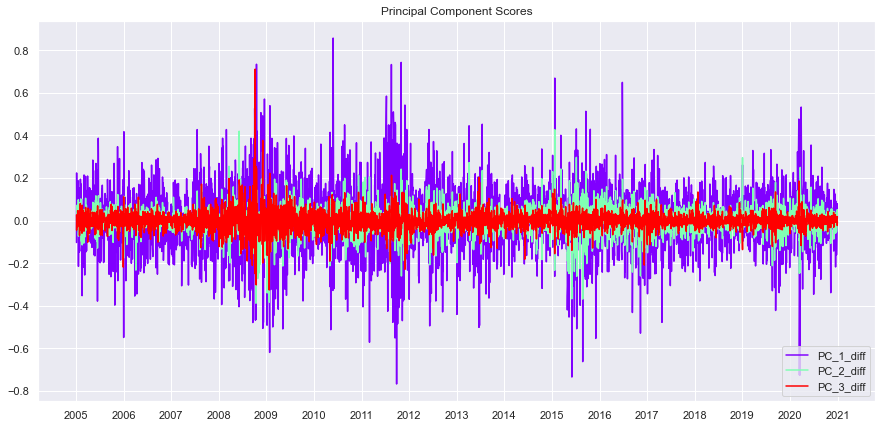

In [49]:
fig, ax = plt.subplots(1, 1, figsize = (15,7))

pc_idx_diff = [i+"_diff" for i in pc_idx]
colors = rainbow(pc_idx_diff)

# Plotting
for i in pc_idx_diff:
    plt.plot(pc_scores[i], c = colors[i], label = i)

# Formatting
ax.set_title ("Principal Component Scores")
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_major_locator(years_loc)
ax.xaxis.set_minor_locator(months_loc)

ax.legend(loc = "lower right")
plt.show()

In [50]:
for i in pc_idx_diff:
    underline (f'Stationarity-Test: {i}')
    print (adf_test(df = pc_scores, col = i, alpha = "5%"))

Stationarity-Test: PC_1_diff
{'adf_stat': -17.0648, 'p_val': 0.0, 'threshold': -2.8623, 'stationary': 'yes'}
Stationarity-Test: PC_2_diff
{'adf_stat': -56.3892, 'p_val': 0.0, 'threshold': -2.8622, 'stationary': 'yes'}
Stationarity-Test: PC_3_diff
{'adf_stat': -16.4127, 'p_val': 0.0, 'threshold': -2.8623, 'stationary': 'yes'}


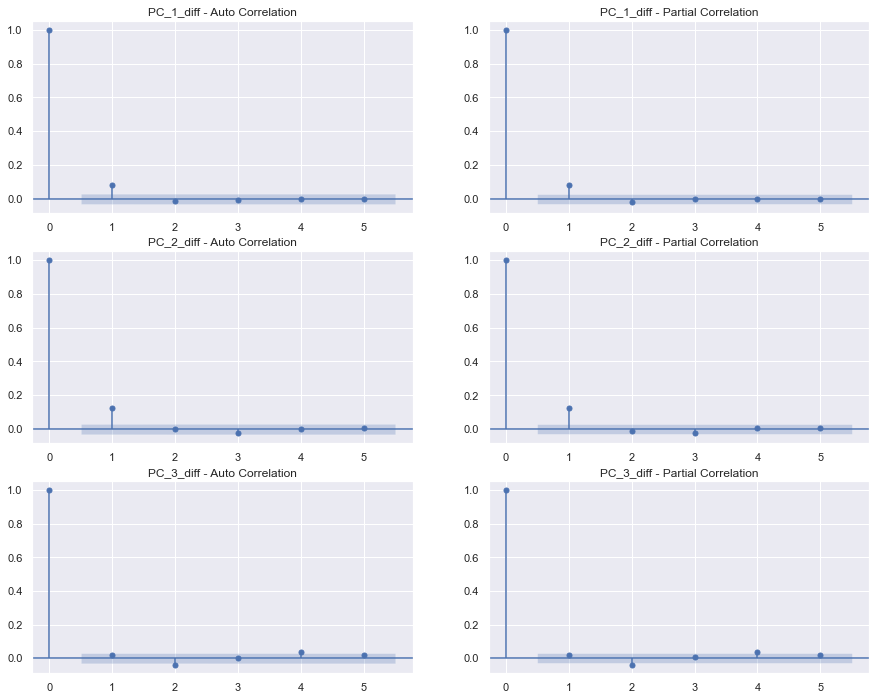

In [51]:
fig, ax = plt.subplots(k, 2, figsize=(15,4*k))

for i,j in enumerate (pc_idx_diff):
    plot_acf (pc_scores[j], lags= lag, ax=ax[i][0], title=j+" - Auto Correlation")
    plot_pacf(pc_scores[j], lags= lag, ax=ax[i][1], title=j+" - Partial Correlation")

plt.show()

### 6 Stress Scenarios
***

In [52]:
# Shift in PC1
unit = 30
trail = 24
pc_shift = dict()
pc_shift_idx = pc_scores.index[unit:]


# Create shifts for each pc
for i in pc_idx2:
    pc_shift[i] = pc_model.eig_scores[i].diff(unit)
    pc_shift[i] = pc_shift[i].dropna()
    
    # Test shifts for stationarity
    stationary = adf_test(pd.DataFrame(pc_shift[i]), i, "5%")
    print (f'{i}: {stationary}')

PC_1: {'adf_stat': -6.317, 'p_val': 0.0, 'threshold': -2.8623, 'stationary': 'yes'}
PC_2: {'adf_stat': -5.558, 'p_val': 0.0, 'threshold': -2.8623, 'stationary': 'yes'}
PC_3: {'adf_stat': -6.6324, 'p_val': 0.0, 'threshold': -2.8623, 'stationary': 'yes'}


In [53]:
# Create up and down scenarios
pc_scores_up, pc_scores_down = dict(), dict()

# Iterate through first 3 PCs
for j in pc_idx2:
    
    # For each PC find highest/lowest 5% shift
    up, down = list(), list()
    
    for i in range(len(pc_shift_idx)):
        temp = pc_shift[j][i:i+unit*trail].sort_values()
        obs = int(len(temp)*0.05)
        
        up.append(temp[obs])
        down.append(temp[-obs])
    
    # Add shift to PC score
    pc_scores_up[j] = pc_scores[j].iloc[unit:] + pd.Series(up, index=pc_shift_idx)
    pc_scores_down[j] = pc_scores[j].iloc[unit:] + pd.Series(down, index=pc_shift_idx)

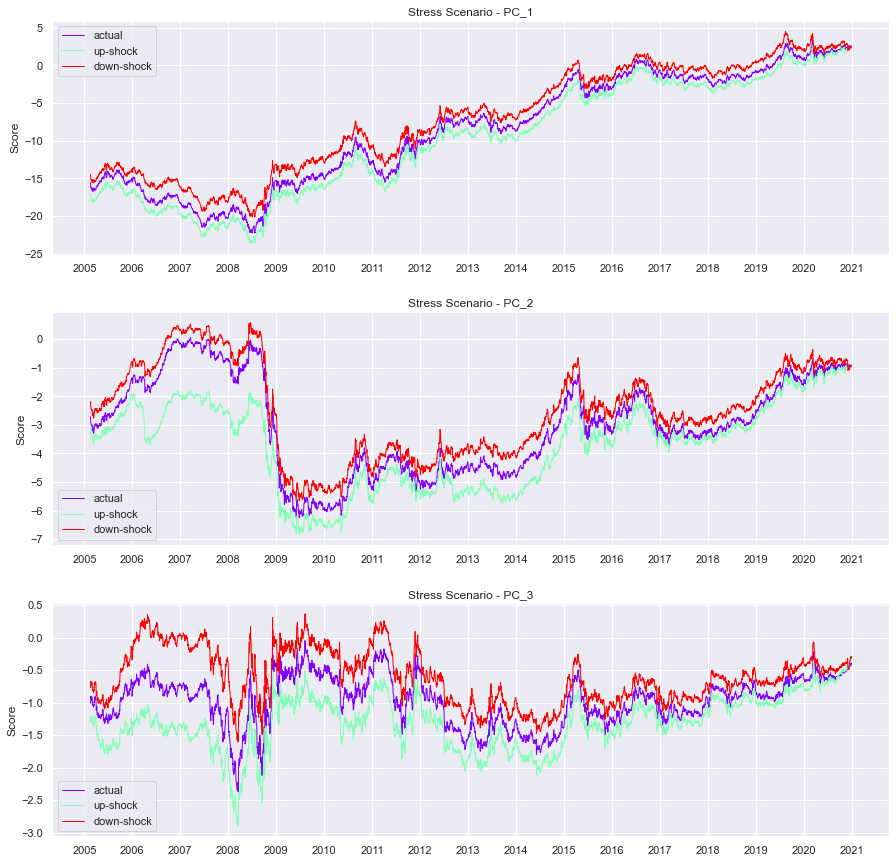

In [54]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,15))
color = rainbow(["actual","up","down"])

# Plots
for i,j in enumerate(pc_idx2):
    ax[i].plot (pc_scores[j].iloc[unit:], c=color["actual"], label="actual", linewidth=1)
    ax[i].plot (pc_scores_up[j], c=color["up"], label="up-shock", linewidth=1)
    ax[i].plot (pc_scores_down[j], c=color["down"], label="down-shock", linewidth=1)

    # Formatting
    ax[i].set_title (f'Stress Scenario - {j}')
    ax[i].set_ylabel ("Score")
    ax[i].xaxis.set_major_formatter(years_fmt)
    ax[i].xaxis.set_major_locator(years_loc)
    ax[i].xaxis.set_minor_locator(months_loc)
    ax[i].legend()
    
plt.subplots_adjust(hspace=0.25)
plt.show()

In [55]:
# Create dictionary of dataframes per each PC
pc_yields_up, pc_yields_down = dict(), dict()

for i in pc_idx2:

    # Dataframe of pc scores, where only 1 PC is stressed
    temp1 = pc_scores.iloc[unit:,:3].copy()
    temp1[i] = pc_scores_up[i]

    temp2 = pc_scores.iloc[unit:,:3].copy()
    temp2[i] = pc_scores_down[i]

    # Backtransformed pc scores into stressed model yields
    pc_yields_up[i] = np.matrix(temp1) * np.matrix(pc_vect_inv)
    pc_yields_up[i] = pd.DataFrame(data=pc_yields_up[i], columns=mat_all, index=pc_shift_idx)

    pc_yields_down[i] = np.matrix(temp2) * np.matrix(pc_vect_inv)
    pc_yields_down[i] = pd.DataFrame(data=pc_yields_down[i], columns=mat_all, index=pc_shift_idx)

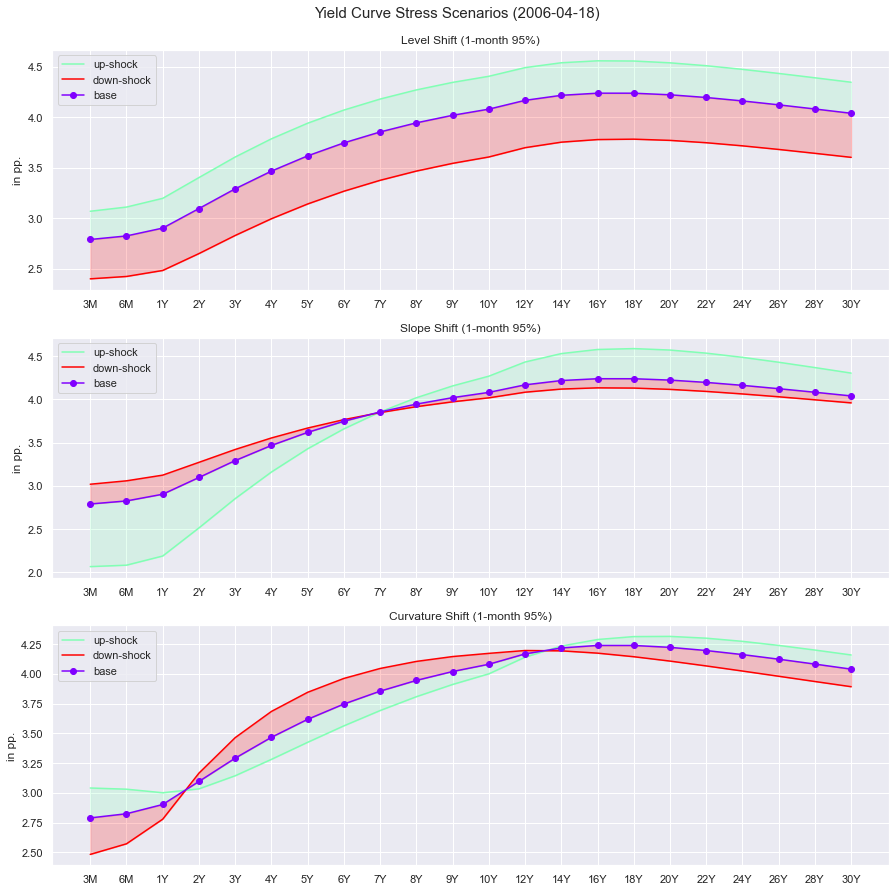

In [71]:
element = 300
date = pc_yields.index[element+unit].strftime("%Y-%m-%d")

fig, ax = plt.subplots(3, 1, figsize = (15,15))
fig.suptitle("Yield Curve Stress Scenarios ("+date+")", fontsize=15, y=0.92)
color = rainbow(["actual","up","down"])


# Create plot
for i,j in enumerate (pc_idx2):
    
    up   = pc_yields_up[j].iloc[element]
    down = pc_yields_down[j].iloc[element]
    act  = pc_yields.iloc[element+unit]
    
    ax[i].plot(mat_all, up, label="up-shock", c=color["up"])
    ax[i].plot(mat_all, down, label="down-shock", c=color["down"])
    ax[i].plot(mat_all, act, label="base", c=color["actual"], marker="o")
    
    ax[i].fill_between(mat_all, up, act, color = color["up"], alpha = 0.2)
    ax[i].fill_between(mat_all, down, act, color = color["down"], alpha = 0.2)
    
    ax[i].set_ylabel ("in pp.")
    ax[i].legend()


# Formatting
ax[0].set_title ("Level Shift (1-month 95%)")
ax[1].set_title ("Slope Shift (1-month 95%)")
ax[2].set_title ("Curvature Shift (1-month 95%)")


plt.show()

### 7 Prediction
***

#### 7.1 Model Fit

In [159]:
# Train-test split for model yields
pc_yields_train = pc_yields[pc_yields.index < test_start]
pc_yields_test  = pc_yields[pc_yields.index >= test_start]

# Train-test split for pc scores
pc_scores_train = pc_scores[pc_scores.index < test_start]
pc_scores_test  = pc_scores[pc_scores.index >= test_start]

# Last train observation
pc_scores_last_train = pc_scores_train.iloc[-1,:k]
pc_scores_last_train

PC_1   -1.850089
PC_2   -3.304227
PC_3   -0.941089
Name: 2017-12-29 00:00:00, dtype: float64

In [160]:
model = ar.Model(train=pc_scores_train, 
                 test=pc_scores_test, 
                 last_train=pc_scores_last_train,
                 alpha=0.05,
                 diff=diff)

In [161]:
model.fit(lag=lag)

                                   PC_1_diff                                    
                               AR Model Results                               
Dep. Variable:                      y   No. Observations:                 3324
Model:                          AR(5)   Log Likelihood                1427.123
Method:                          cmle   S.D. of innovations              0.157
Date:                Sat, 20 Feb 2021   AIC                             -3.694
Time:                        14:54:07   BIC                             -3.681
Sample:                             0   HQIC                            -3.689
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.003      1.486      0.137      -0.001       0.009
L1.y           0.0797      0.017      4.587      0

#### 7.2 Model Results

In [162]:
pc_scores_pred = model.predict(steps=steps, components_pred=["PC_1_diff","PC_2_diff"])
pc_scores_pred.iloc[:5,:10]

,PC_1,PC_2,PC_3
2018-01-02,-1.857364,-3.316788,-0.941089
2018-01-03,-1.959128,-3.311014,-0.989192
2018-01-04,-1.888378,-3.217833,-1.020644
2018-01-05,-1.936538,-3.182114,-1.003372
2018-01-08,-1.913026,-3.181027,-1.025474


In [149]:
yield_pred = model.back_transform(pc_vect_inv=pc_vect_inv, maturities=mat_all)
yield_pred.iloc[:5,:10]

,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y
2018-01-02,-0.783736,-0.773355,-0.741369,-0.637701,-0.495596,-0.333292,-0.165543,-0.002400,0.150194,0.289338
2018-01-03,-0.744848,-0.737262,-0.710970,-0.617042,-0.481519,-0.322917,-0.156693,0.006407,0.159886,0.300440
2018-01-04,-0.685891,-0.695266,-0.693239,-0.623080,-0.495096,-0.338150,-0.172037,-0.009088,0.143784,0.283299
2018-01-05,-0.661700,-0.674006,-0.675369,-0.606616,-0.477515,-0.319394,-0.152825,0.009785,0.161689,0.299825
2018-01-08,-0.659386,-0.672250,-0.675209,-0.610492,-0.485100,-0.329631,-0.164579,-0.002539,0.149491,0.288213


In [150]:
yield_pred.to_csv("../assets/files/02-output/prediction.csv")

#### 7.3 Actuals

In [151]:
yield_act = clean_rates[clean_rates.index >= test_start].iloc[:steps]
yield_act.iloc[:5,:10]

,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y
2018-01-02,-0.745998,-0.738445,-0.712228,-0.618449,-0.483050,-0.324544,-0.158394,0.004649,0.158085,0.298607
2018-01-03,-0.689726,-0.699190,-0.696930,-0.625850,-0.496899,-0.339074,-0.172192,-0.008581,0.144852,0.284841
2018-01-04,-0.664711,-0.677090,-0.678375,-0.609208,-0.479648,-0.321098,-0.154146,0.008797,0.160989,0.299369
2018-01-05,-0.659469,-0.672334,-0.675266,-0.610466,-0.484993,-0.329451,-0.164337,-0.002245,0.149828,0.288587
2018-01-08,-0.646781,-0.664524,-0.675209,-0.620244,-0.499954,-0.346989,-0.182959,-0.021089,0.131257,0.270563


#### 7.4 Benchmark

In [152]:
yield_pred_bm = yield_act.shift(1)
yield_pred_bm.iloc[0] = clean_rates[clean_rates.index < test_start].iloc[-1]
yield_pred_bm.iloc[:5,:10]

,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y
2018-01-02,-0.780057,-0.769592,-0.737874,-0.635217,-0.494164,-0.332811,-0.165891,-0.003460,0.148531,0.287169
2018-01-03,-0.745998,-0.738445,-0.712228,-0.618449,-0.483050,-0.324544,-0.158394,0.004649,0.158085,0.298607
2018-01-04,-0.689726,-0.699190,-0.696930,-0.625850,-0.496899,-0.339074,-0.172192,-0.008581,0.144852,0.284841
2018-01-05,-0.664711,-0.677090,-0.678375,-0.609208,-0.479648,-0.321098,-0.154146,0.008797,0.160989,0.299369
2018-01-08,-0.659469,-0.672334,-0.675266,-0.610466,-0.484993,-0.329451,-0.164337,-0.002245,0.149828,0.288587


#### 7.5 Error

In [153]:
e_pred = yield_pred - clean_rates_test
e_pred = e_pred[:steps]
e_pred.iloc[:5,:10]

,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y
2018-01-02,-0.037738,-0.034910,-2.914147e-02,-0.019251,-0.012546,-0.008748,-0.007148,-0.007050,-0.007891,-0.009269
2018-01-03,-0.055122,-0.038072,-1.404009e-02,0.008808,0.015380,0.016157,0.015498,0.014988,0.015034,0.015600
2018-01-04,-0.021180,-0.018176,-1.486368e-02,-0.013872,-0.015449,-0.017052,-0.017891,-0.017885,-0.017205,-0.016070
2018-01-05,-0.002232,-0.001672,-1.025734e-04,0.003851,0.007478,0.010057,0.011512,0.012030,0.011861,0.011238
2018-01-08,-0.012605,-0.007726,1.877462e-07,0.009752,0.014854,0.017358,0.018380,0.018550,0.018233,0.017650


In [154]:
e_naive = yield_pred_bm - clean_rates_test
e_naive = e_naive[:steps]
e_naive.iloc[:5,:10]

,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y
2018-01-02,-0.034059,-0.031147,-0.025646,-0.016768,-0.011114,-0.008267,-0.007497,-0.008109,-0.009554,-0.011437
2018-01-03,-0.056272,-0.039254,-0.015298,0.007400,0.013849,0.014530,0.013798,0.013231,0.013233,0.013766
2018-01-04,-0.025015,-0.022100,-0.018555,-0.016642,-0.017251,-0.017976,-0.018045,-0.017379,-0.016137,-0.014528
2018-01-05,-0.005242,-0.004756,-0.003109,0.001258,0.005345,0.008353,0.010191,0.011042,0.011161,0.010782
2018-01-08,-0.012688,-0.007811,-0.000058,0.009777,0.014961,0.017537,0.018622,0.018844,0.018571,0.018023


In [155]:
rmse_pred  = np.sqrt((e_pred**2).sum(axis=1))
rmse_naive = np.sqrt((e_naive**2).sum(axis=1))

print (f"RMSE of prediction model:{rmse_pred.sum()/steps}")
print (f"RMSE of benchmark model: {rmse_naive.sum()/steps}")

RMSE of prediction model:0.09091038814434066
RMSE of benchmark model: 0.09037258245550454


### 8 Evaluation
***

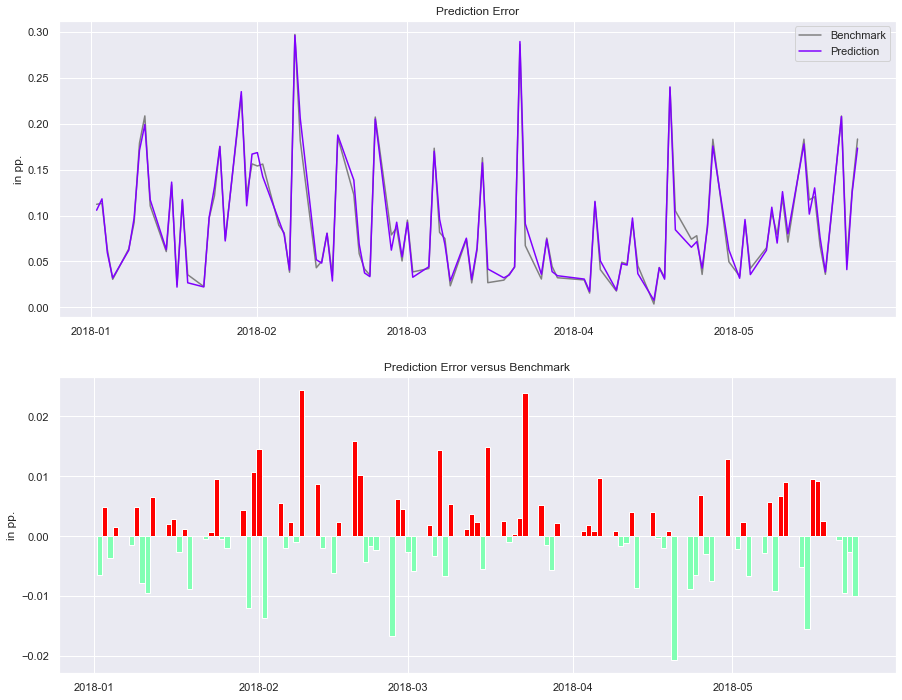

In [118]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,12))
color = rainbow(["pred","neg","pos"])
color_bar=(rmse_pred-rmse_naive > 0).map({True: color["pos"], False: color["neg"]})

# Plots
ax1.plot(rmse_naive, c="grey", label="Benchmark")
ax1.plot(rmse_pred, c=color["pred"], label="Prediction")
ax2.bar(x=rmse_pred.index, height=rmse_pred-rmse_naive, width=1, color=color_bar)



# Formatting
ax1.set_title ("Prediction Error")
ax1.set_ylabel ("in pp.")
ax1.xaxis.set_major_formatter(months_fmt)
ax1.xaxis.set_major_locator(months_loc)
ax1.legend()

ax2.set_title ("Prediction Error vs. Benchmark")
ax2.set_ylabel ("in pp.")
ax2.xaxis.set_major_formatter(months_fmt)
ax2.xaxis.set_major_locator(months_loc)

plt.show()

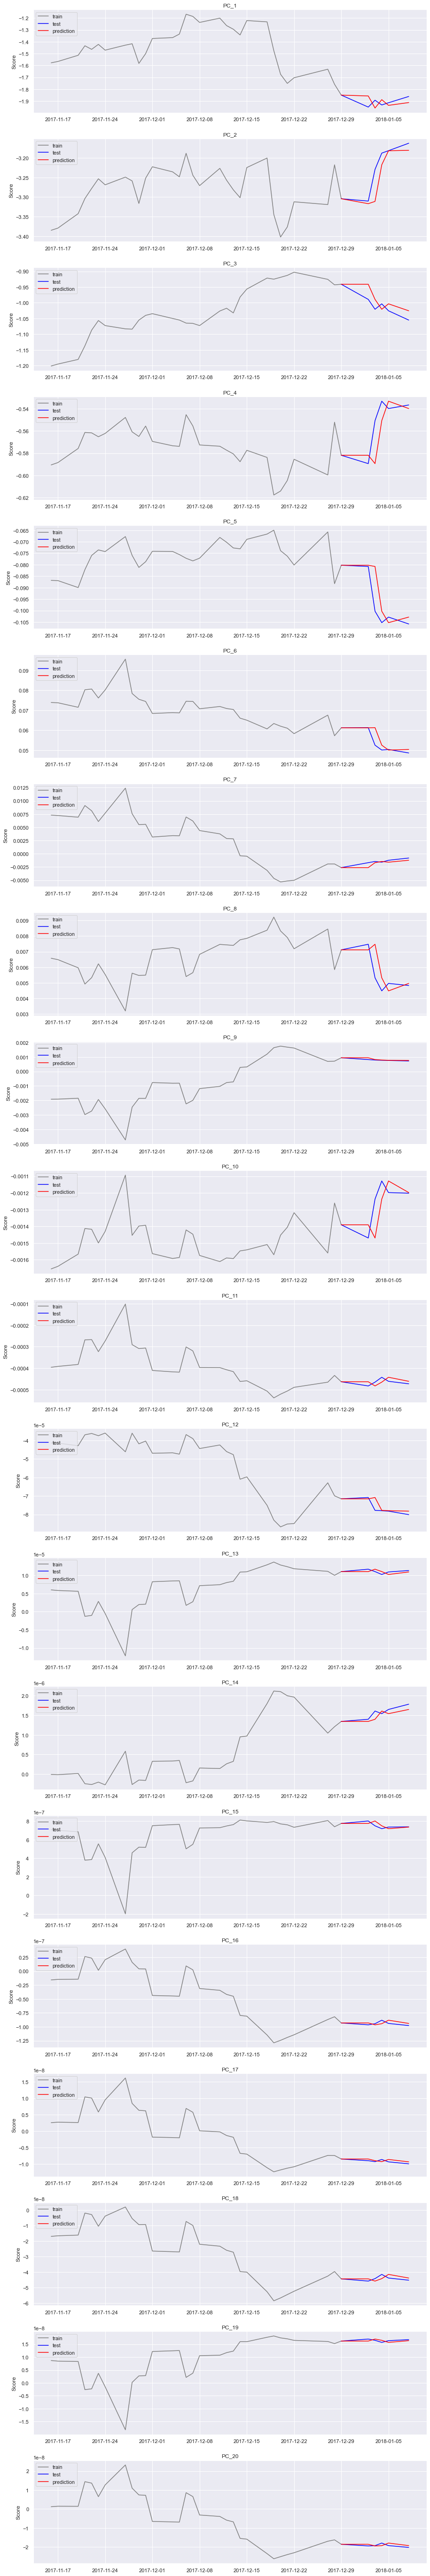

In [119]:
days_hist = 30
horizon = 5

fig, ax = plt.subplots(k, 1, figsize = (15,5*k))

chart_train = pc_scores_train.iloc[-days_hist:,:]
chart_test = pd.concat([pc_scores_train.iloc[-1:], pc_scores_test.iloc[:horizon]], axis = 0)
chart_pred = pd.concat([pc_scores_train.iloc[-1:], pc_scores_pred[:horizon]], axis =0)

for i,j in enumerate (pc_idx):
    
    # Ploting
    ax[i].plot(chart_train[j], c="grey", label = "train")
    ax[i].plot(chart_test[j], c="blue",  label = "test")
    ax[i].plot(chart_pred[j], c="red",   label = "prediction")

    # Formatting
    ax[i].set_title (j)
    ax[i].set_ylabel ("Score")
    
    ax[i].xaxis.set_major_formatter(days_fmt)
    ax[i].xaxis.set_major_locator(days_loc)
    ax[i].legend(loc="upper left")

plt.subplots_adjust(hspace=0.25)
plt.show()

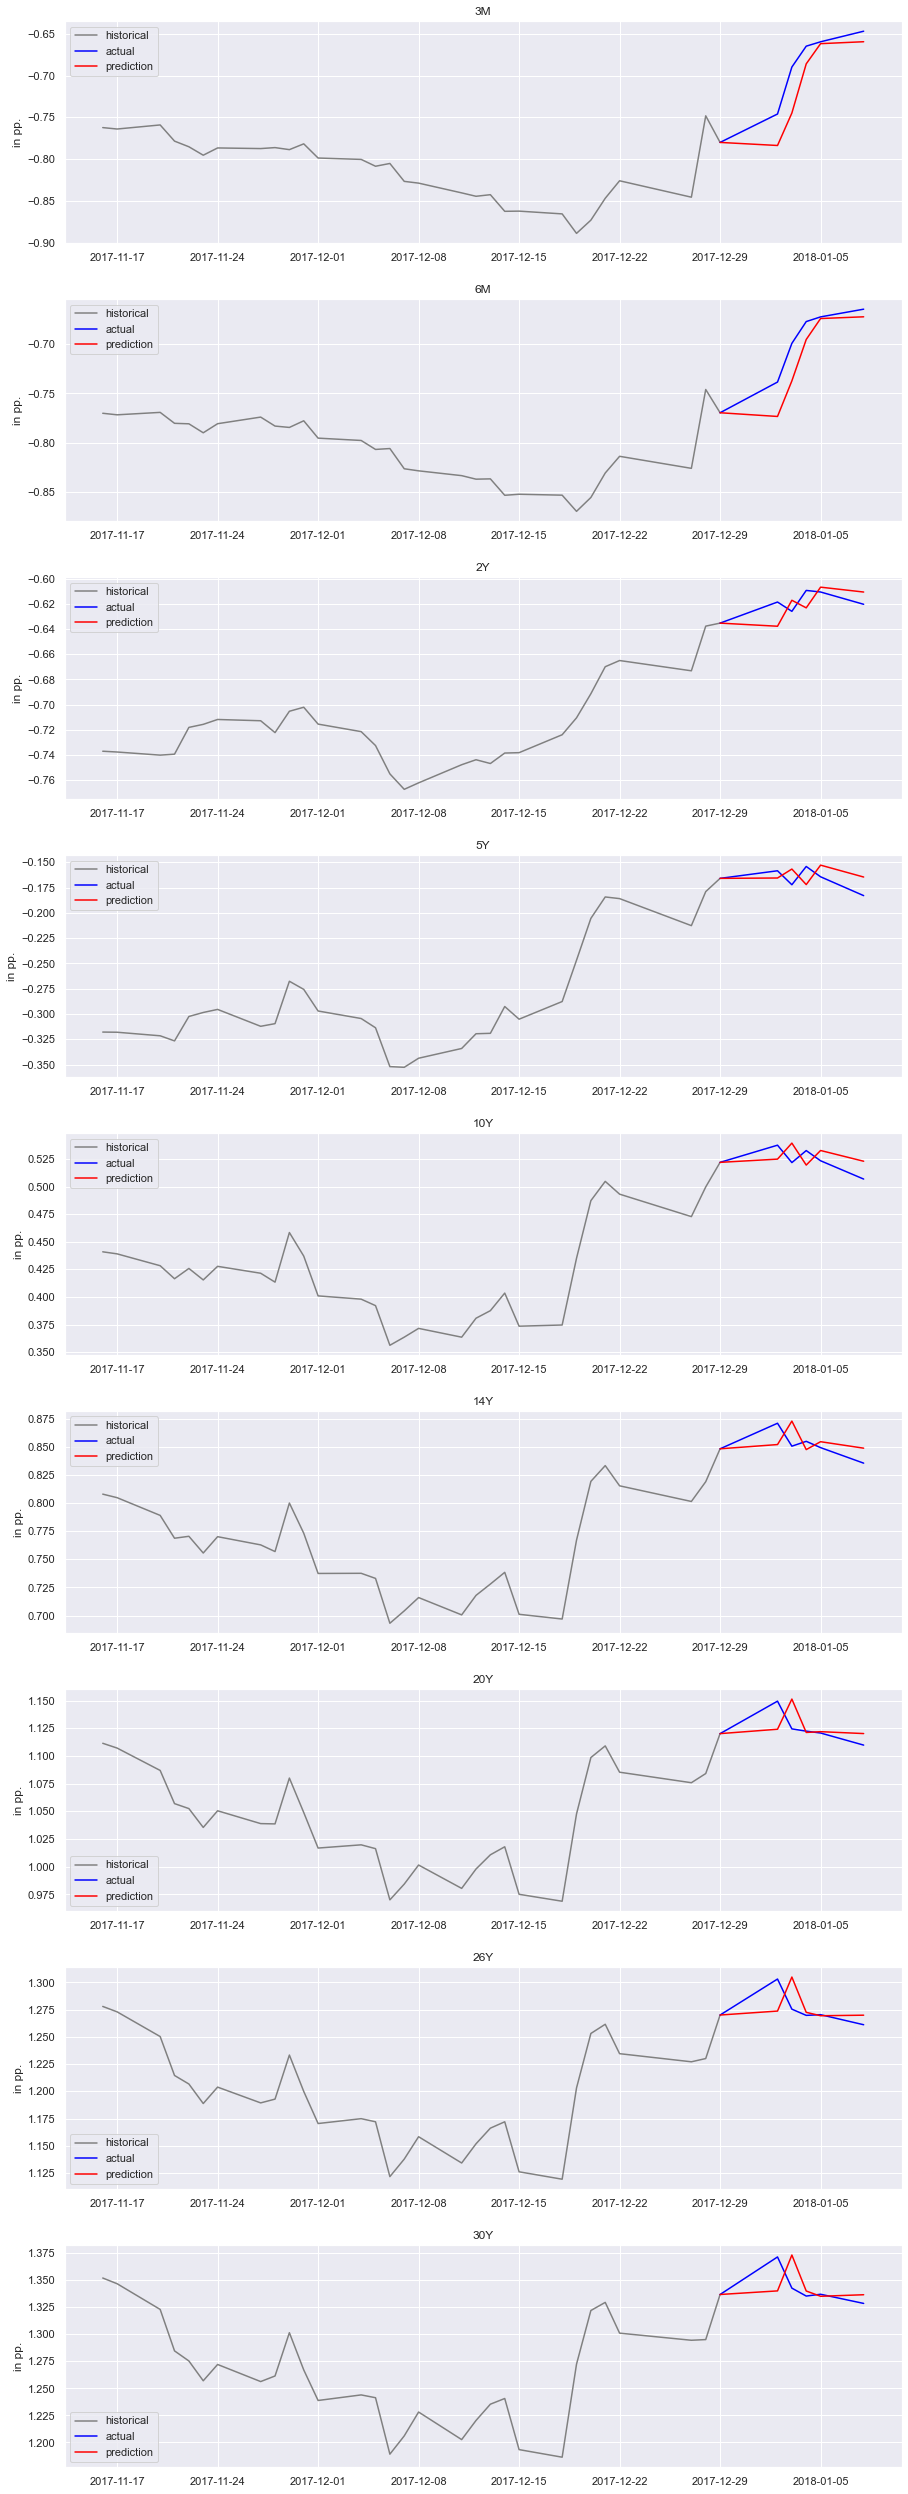

In [120]:
fig, ax = plt.subplots(nrows = len(mat_vis), ncols = 1, figsize = (15,5*len(mat_vis)))

chart_hist = clean_rates_train.iloc[-days_hist:,:]
chart_act  = pd.concat([clean_rates_train.iloc[-1:], yield_act[:horizon]], axis = 0)
chart_pred = pd.concat([clean_rates_train.iloc[-1:], yield_pred[:horizon]], axis = 0)

for i,j in enumerate(mat_vis):
    ax[i].plot (chart_hist[j],          c="grey", label = "historical")
    ax[i].plot (chart_act[j][:steps+1], c="blue", label = "actual")
    ax[i].plot (chart_pred[j],          c="red",  label = "prediction")

    ax[i].set_title (j)
    ax[i].set_ylabel ("in pp.")

    ax[i].xaxis.set_major_formatter(days_fmt)
    ax[i].xaxis.set_major_locator(days_loc)
    ax[i].legend()

plt.subplots_adjust(hspace=0.25)
plt.show()

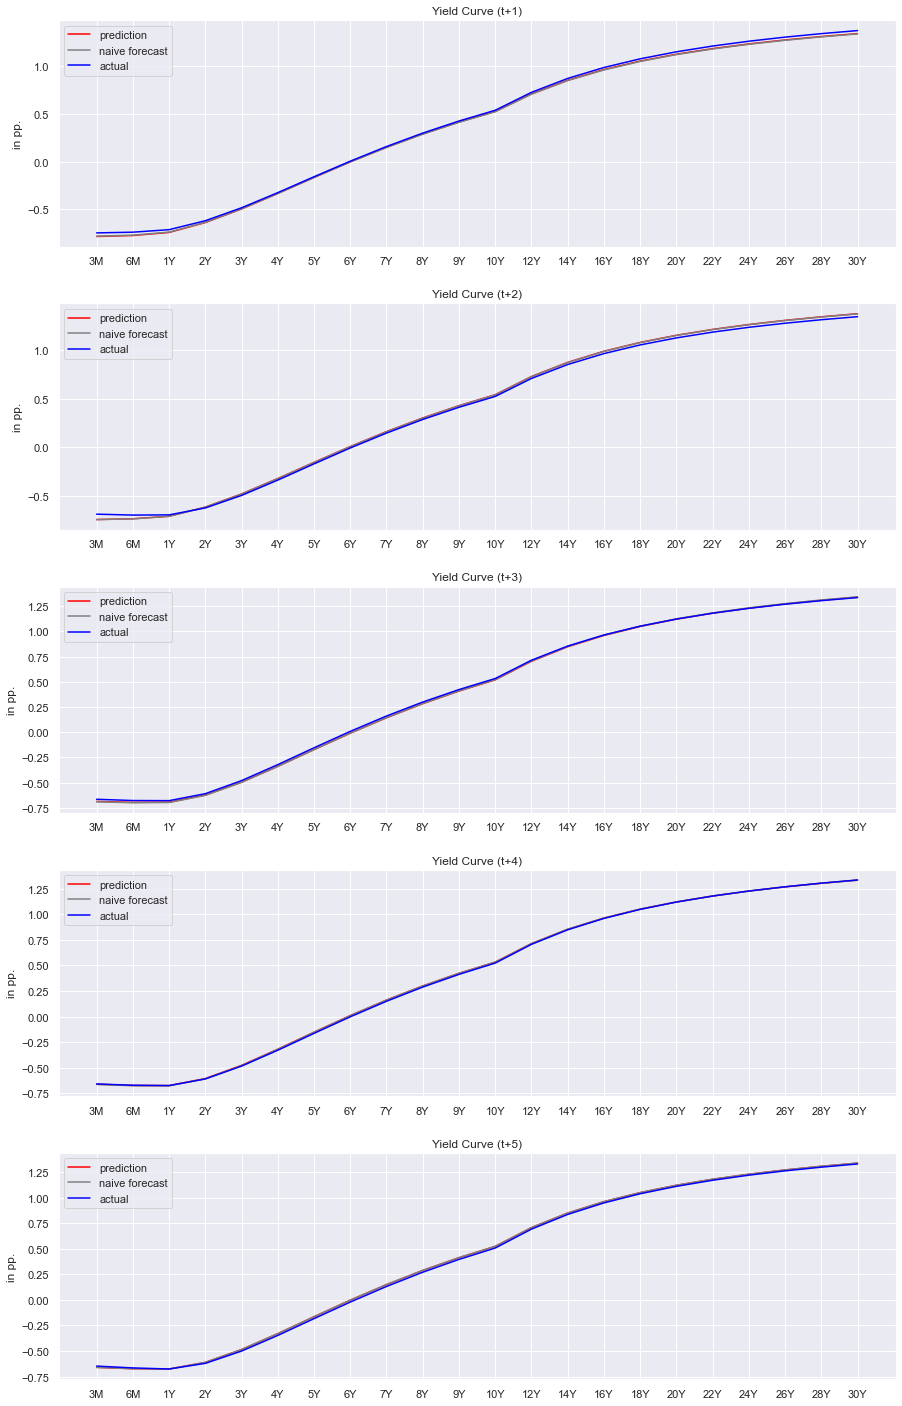

In [121]:
fig, ax = plt.subplots(nrows = horizon, 
                       ncols = 1, 
                       figsize = (15,horizon*5))

for i in range(horizon):
    ax[i].plot (yield_pred.iloc[i,:],    c="red",  label = "prediction")
    ax[i].plot (yield_pred_bm.iloc[i,:], c="grey", label = "naive forecast")
    ax[i].plot (yield_act.iloc[i,:],     c="blue", label = "actual")

    # Format
    ax[i].set_title (f'Yield Curve (t+{i+1})')
    ax[i].set_ylabel ("in pp.")
    ax[i].legend()

    
plt.subplots_adjust(hspace=0.25)
plt.show()

In [122]:
%matplotlib notebook

# (1) Creating figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9.5,4))
days = 15
horizon = 3


# (2) Prepare objects
y_hist = pc_scores_test["PC_1"].iloc[0:days].copy()
y_act  = pc_scores_test["PC_1"].iloc[days-1:days+horizon].copy()
y_pred = pc_scores_pred["PC_1"].iloc[days-1:days+horizon].copy()
y_pred[0] = y_hist[-1]

x_hist = y_hist.index
x_pred = y_act.index


# (3) Initialize objects
line_hist, = ax.plot(x_hist, y_hist, c="grey", linewidth=1, label = "historical")
line_act,  = ax.plot(x_pred, y_act,  c="blue", linewidth=1, label = "prediction")
line_pred, = ax.plot(x_pred, y_pred, c="red",  linewidth=1, label = "actual")
    

# (4) Fixed formatting
ax.set_title("PC 1 - Prediction", fontsize = 10)
ax.set_ylabel("Score", fontsize = 8)

ax.tick_params(axis="both", which="major", labelsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.xaxis.set_major_formatter(days_fmt)
ax.xaxis.set_major_locator(days_loc)


# (4) Animation function
def animate(i):
    
    # (5.1) Update data
    y_hist = pc_scores_test["PC_1"].iloc[0+i:days+i].copy()
    y_act  = pc_scores_test["PC_1"].iloc[days-1+i:days+horizon+i].copy()
    y_pred = pc_scores_pred["PC_1"].iloc[days-1+i:days+horizon+i].copy()
    y_pred[0] = y_hist[-1]
    
    x_hist = y_hist.index
    x_pred = y_act.index

    line_hist.set_data(x_hist, y_hist)
    line_act.set_data(x_pred, y_act)    
    line_pred.set_data(x_pred, y_pred)

    # (5.2) Variable formatting
    ax.set_xlim(x_hist.min(), x_hist.max() + dt.timedelta(days=horizon+3))
    ax.set_ylim(np.floor(y_hist.min())-0.5, np.ceil(y_hist.max())+0.5)
    
    return line_hist
        

# (5) Animation iterating through the steps array
ani = FuncAnimation(fig, animate, np.arange(1,steps,1), interval=200, blit=True, repeat = False)
plt.show()

<IPython.core.display.Javascript object>

In [94]:
%matplotlib inline